# Preprocessing

In [30]:
# Libraries and prameters
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import KNNImputer, SimpleImputer


# Functions

In [31]:
# Import data
data = pd.read_csv("../preproc_data/data_with_new_features.csv", index_col=0)
data.head(2)

,temp_f,humidity,pitcher_pitch_count_at_bat_start,outs_at_start,hitter_position,hitter_previous_stats_szn,rolling_1ab,rolling_3ab,rolling_10ab,hitter_previous_stats_szn_slug,rolling_1ab_slug,rolling_3ab_slug,rolling_10ab_slug,pitcher_previous_stats_szn,rolling_1pitch,rolling_3pitch,rolling_10pitch,pitcher_previous_stats_szn_bases,rolling_1pitch_bases,rolling_3pitch_bases,rolling_10pitch_bases,handed_matchup,match_up_ab_count_delta,hitter_strikes_eff,hitter_balls_eff,pitcher_strikes_spread,pitcher_balls_spread,hitter_success_speed,pitcher_speed,hitter_fast_eff,hitter_offspeed_eff,pitcher_fast_spread,pitcher_offspeed_spread,y_target
72,42.0,26.0,70.0,2.0,OF,0.333333,0.0,0.5,0.5,1.333333,0.0,2.0,2.0,0.250000,0.0,0.0,0.200000,0.550000,0.0,0.0,0.500000,0,17,0.5,0.0,0.600000,0.400000,92.8,93.131579,0.0,0.5,0.300000,0.700000,0
93,50.0,29.0,22.0,2.0,IF,0.500000,1.0,1.0,1.0,0.500000,1.0,1.0,1.0,0.285714,0.0,0.0,0.333333,0.285714,0.0,0.0,0.333333,0,5,0.0,1.0,0.714286,0.285714,89.7,104.266667,1.0,0.0,0.428571,0.571429,0


In [34]:
data = data.drop(columns=["temp_f", "humidity"])

In [35]:
X = data.drop(columns=["y_target"])
y = data.y_target

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

In [37]:
data.describe()

,pitcher_pitch_count_at_bat_start,outs_at_start,hitter_previous_stats_szn,rolling_1ab,rolling_3ab,rolling_10ab,hitter_previous_stats_szn_slug,rolling_1ab_slug,rolling_3ab_slug,rolling_10ab_slug,pitcher_previous_stats_szn,rolling_1pitch,rolling_3pitch,rolling_10pitch,pitcher_previous_stats_szn_bases,rolling_1pitch_bases,rolling_3pitch_bases,rolling_10pitch_bases,handed_matchup,match_up_ab_count_delta,hitter_strikes_eff,hitter_balls_eff,pitcher_strikes_spread,pitcher_balls_spread,hitter_success_speed,pitcher_speed,hitter_fast_eff,hitter_offspeed_eff,pitcher_fast_spread,pitcher_offspeed_spread,y_target
count,139111.000000,139111.000000,139111.000000,139111.000000,139111.000000,139111.000000,139111.000000,139111.000000,139111.000000,139111.000000,139111.000000,139111.000000,139111.000000,139111.000000,139111.000000,139111.000000,139111.000000,139111.000000,139111.000000,139111.000000,139111.000000,139111.000000,139111.000000,139111.000000,139111.000000,139111.000000,139111.000000,139111.000000,139111.000000,139111.000000,139111.000000
mean,29.589544,0.970081,0.323943,0.318609,0.318826,0.319265,0.472545,0.467339,0.467957,0.468493,0.312974,0.317674,0.317202,0.316521,0.453419,0.465952,0.465052,0.463295,0.530806,-11.719030,0.294276,0.384826,0.657745,0.342255,89.318355,91.376592,0.333161,0.312807,0.571482,0.428518,0.318249
std,27.095511,0.816864,0.062010,0.465939,0.271786,0.153511,0.114751,0.863627,0.504281,0.284324,0.074057,0.465574,0.272727,0.156813,0.134944,0.862665,0.503223,0.289304,0.499052,143.524102,0.073353,0.125361,0.080799,0.080799,1.535793,8.143492,0.085155,0.097880,0.242972,0.242972,0.465799
min,0.000000,0.000000,0.031250,0.000000,0.000000,0.000000,0.031250,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-563.000000,0.000000,0.000000,0.000000,0.000000,50.900000,42.840000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7.000000,0.000000,0.292135,0.000000,0.000000,0.200000,0.413043,0.000000,0.000000,0.300000,0.277778,0.000000,0.000000,0.200000,0.390110,0.000000,0.000000,0.300000,0.000000,-90.000000,0.261194,0.313559,0.621795,0.301587,88.697826,88.342812,0.291667,0.267284,0.409836,0.244186,0.000000
50%,20.000000,1.000000,0.322917,0.000000,0.333333,0.300000,0.471698,0.000000,0.333333,0.400000,0.309278,0.000000,0.333333,0.300000,0.445652,0.000000,0.333333,0.400000,1.000000,-5.000000,0.294118,0.377049,0.663043,0.336957,89.374359,90.163158,0.333333,0.312500,0.581320,0.418680,0.000000
75%,50.000000,2.000000,0.355140,1.000000,0.333333,0.400000,0.528226,1.000000,0.666667,0.600000,0.343915,1.000000,0.333333,0.400000,0.504950,1.000000,0.666667,0.600000,1.000000,57.000000,0.326923,0.454545,0.698413,0.378205,90.056544,92.402618,0.372093,0.357143,0.755814,0.590164,1.000000
max,117.000000,2.000000,1.000000,1.000000,1.000000,1.000000,3.000000,4.000000,4.000000,4.000000,1.000000,1.000000,1.000000,1.000000,4.000000,4.000000,4.000000,4.000000,1.000000,632.000000,1.000000,1.000000,1.000000,1.000000,101.600000,203.300000,1.000000,1.000000,1.000000,1.000000,1.000000


In [38]:
# Num features
# num_col = ["temp_f", "humidity",
#            "match_up_ab_count_delta", "hitter_success_speed", "pitcher_speed",
#            "pitcher_pitch_count_at_bat_start", "outs_at_start", ]

num_col = ["pitcher_pitch_count_at_bat_start", "outs_at_start", "hitter_previous_stats_szn_slug",
           "rolling_1ab_slug", "rolling_3ab_slug", "rolling_10ab_slug", "pitcher_previous_stats_szn_bases",
           "rolling_1pitch_bases", "rolling_3pitch_bases", "rolling_10pitch_bases", "match_up_ab_count_delta",
           "hitter_success_speed", "pitcher_speed"]

num_transformer = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    MinMaxScaler()
)

# Cat features
cat_col = ["hitter_position"]
cat_transformer = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(sparse_output=True, drop="if_binary")
)

# Pipeline
preproc_transformer = make_column_transformer(
    (num_transformer, num_col),
    (cat_transformer, cat_col),
    remainder='passthrough'
)

preproc = make_pipeline(preproc_transformer)
preproc

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  ['pitcher_pitch_count_at_bat_start',
                                                   'outs_at_start',
                                                   'hitter_previous_stats_szn_slug',
                                                   'rolling_1ab_slug',
                                                   'rolling_3ab_slug',
                                                   'rolling_10ab_slug',
                                                   'pitcher_previous_stats_szn_bases',
                                                   'rolling_1pitch_bases',
                                                   'rolling_3pitch_bases',
                                                   'rolling_10pitch_bases',
                                                   'match_up_ab_count_delta',
                                                   'hitter_success_speed',
                                                   'pitcher_speed']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(drop='if_binary'))]),
                                                  ['hitter_position'])]))])

In [39]:
preproc.fit(X_train)

X_train_preproc = preproc.transform(X_train)
X_train_preproc = pd.DataFrame(X_train_preproc, columns=preproc.get_feature_names_out(), index=X_train.index)

X_test_preproc = preproc.transform(X_test)
X_test_preproc = pd.DataFrame(X_test_preproc, columns=preproc.get_feature_names_out(), index=X_test.index)

In [40]:
X_train_preproc.shape

(97377, 35)

In [41]:
X_train_preproc.head(2)

,pipeline-1__pitcher_pitch_count_at_bat_start,pipeline-1__outs_at_start,pipeline-1__hitter_previous_stats_szn_slug,pipeline-1__rolling_1ab_slug,pipeline-1__rolling_3ab_slug,pipeline-1__rolling_10ab_slug,pipeline-1__pitcher_previous_stats_szn_bases,pipeline-1__rolling_1pitch_bases,pipeline-1__rolling_3pitch_bases,pipeline-1__rolling_10pitch_bases,pipeline-1__match_up_ab_count_delta,pipeline-1__hitter_success_speed,pipeline-1__pitcher_speed,pipeline-2__hitter_position_C,pipeline-2__hitter_position_DH,pipeline-2__hitter_position_IF,pipeline-2__hitter_position_OF,pipeline-2__hitter_position_P,remainder__hitter_previous_stats_szn,remainder__rolling_1ab,remainder__rolling_3ab,remainder__rolling_10ab,remainder__pitcher_previous_stats_szn,remainder__rolling_1pitch,remainder__rolling_3pitch,remainder__rolling_10pitch,remainder__handed_matchup,remainder__hitter_strikes_eff,remainder__hitter_balls_eff,remainder__pitcher_strikes_spread,remainder__pitcher_balls_spread,remainder__hitter_fast_eff,remainder__hitter_offspeed_eff,remainder__pitcher_fast_spread,remainder__pitcher_offspeed_spread
53892,0.059829,0.5,0.156140,0.25,0.166667,0.250,0.111111,0.25,0.25,0.250,0.476151,0.778011,0.277877,0.0,0.0,1.0,0.0,0.0,0.322917,1.0,0.666667,0.6,0.297980,1.0,0.666667,0.5,1.0,0.298507,0.379310,0.691919,0.308081,0.380000,0.260870,0.454545,0.545455
118732,0.299145,1.0,0.100803,0.00,0.083333,0.175,0.091837,0.00,0.00,0.025,0.420921,0.743922,0.264286,0.0,0.0,1.0,0.0,0.0,0.285311,0.0,0.333333,0.4,0.268707,0.0,0.000000,0.1,0.0,0.292373,0.271186,0.687075,0.312925,0.287805,0.281879,0.510204,0.489796


In [42]:
X_train_preproc.to_csv("../preproc_data/X_train_preproc.csv")
X_test_preproc.to_csv("../preproc_data/X_test_preproc.csv")

y_train.to_csv("../preproc_data/y_train.csv")
y_test.to_csv("../preproc_data/y_test.csv")

pipeline-1__match_up_ab_count_delta            -0.021330
pipeline-2__hitter_position_C                  -0.012739
remainder__pitcher_strikes_spread              -0.011815
remainder__pitcher_fast_spread                 -0.004485
pipeline-2__hitter_position_IF                 -0.004055
pipeline-1__outs_at_start                       0.000691
pipeline-2__hitter_position_DH                  0.002056
pipeline-1__pitcher_pitch_count_at_bat_start    0.002990
pipeline-1__hitter_success_speed                0.004075
remainder__pitcher_offspeed_spread              0.004485
pipeline-1__pitcher_speed                       0.007588
pipeline-1__rolling_3pitch_bases                0.008526
pipeline-2__hitter_position_P                   0.009372
remainder__rolling_3pitch                       0.009925
pipeline-1__rolling_1pitch_bases                0.010191
pipeline-2__hitter_position_OF                  0.010728
remainder__pitcher_balls_spread                 0.011815
remainder__rolling_1pitch      

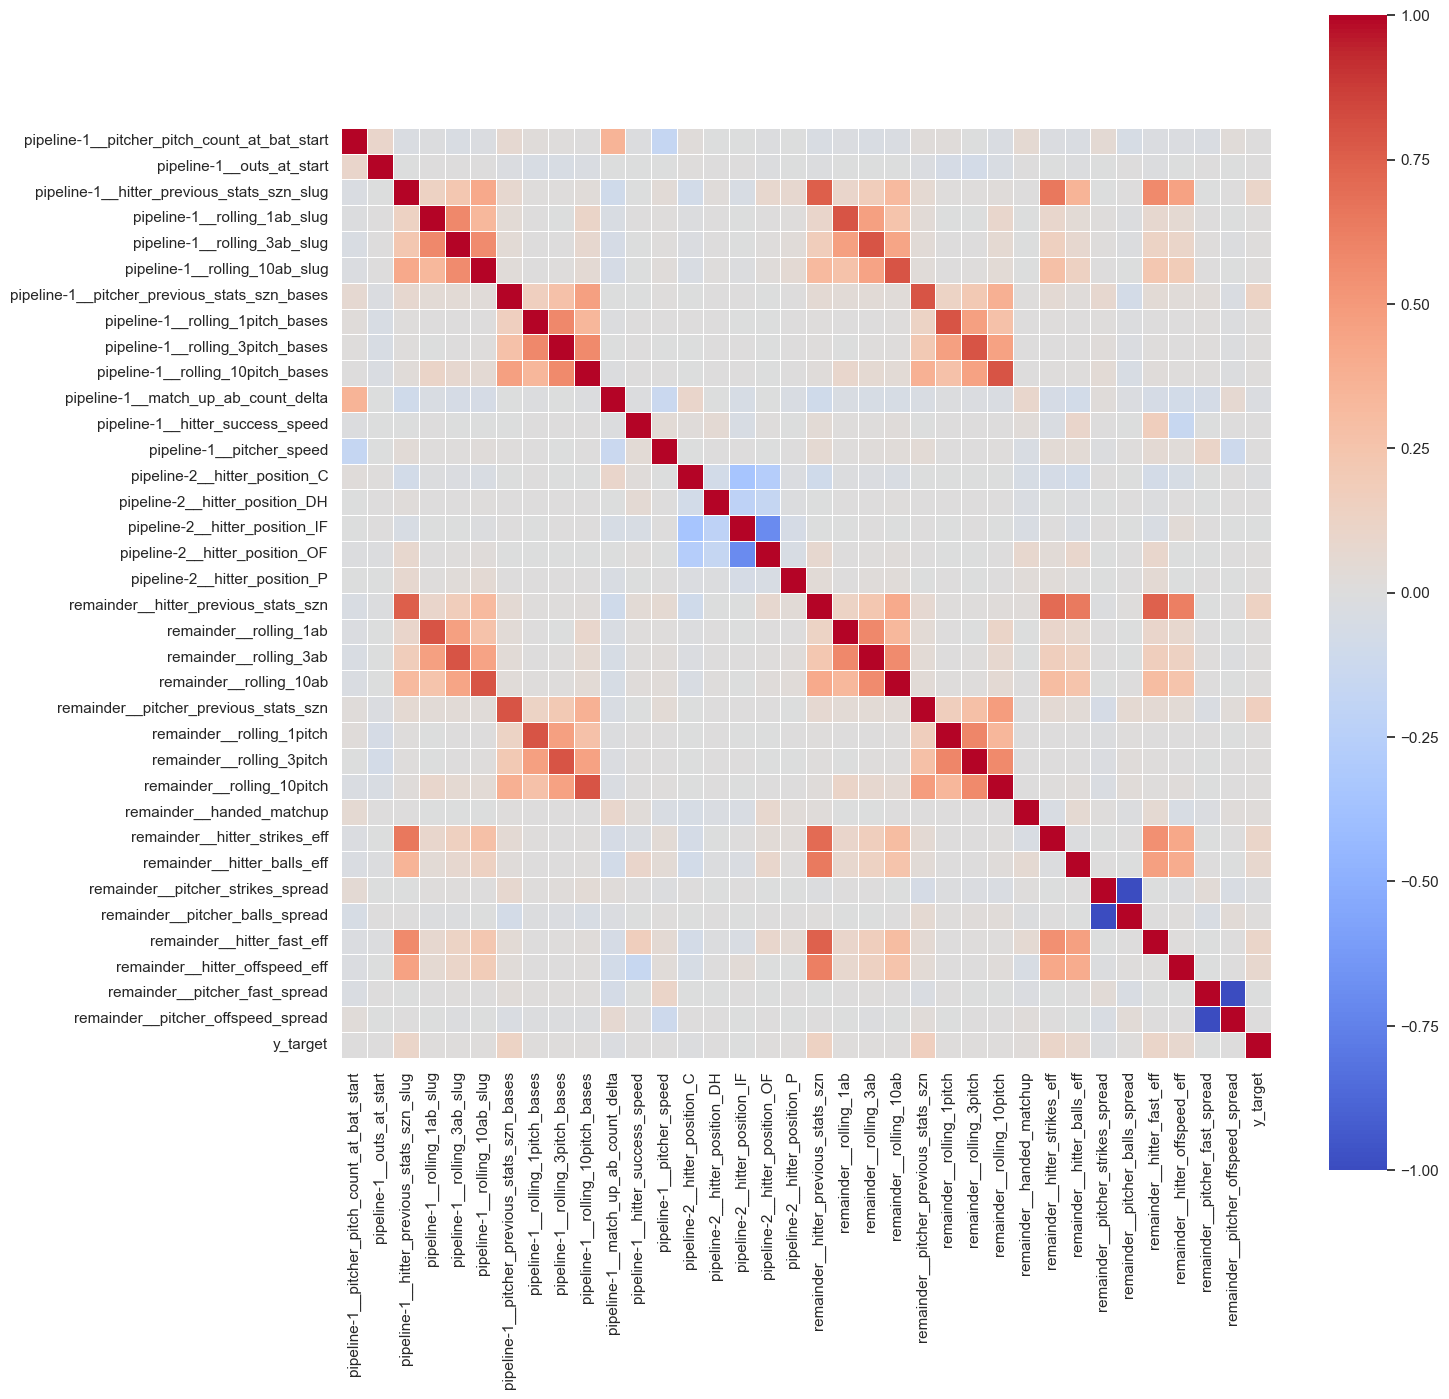

In [43]:
test = X_train_preproc.merge(y_train, right_index=True, left_index=True)
plt.figure(figsize=(15, 15))
sns.set(font_scale=1)
sns.heatmap(test.corr(), cmap='coolwarm', linewidths=.5, cbar=True, square=True)
test.corr()["y_target"].sort_values()